In [1]:
import numpy as np
import tensorflow as tf
import keras
from time import time

## Load the Shakespeare text file / Setup Tokenizer

In [2]:
path_to_file = keras.utils.get_file(
        'shakespeare.txt',
        'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
        )
print(path_to_file)

with open(path_to_file) as f:
    shakespeare_text = f.read()
print(shakespeare_text[:148])

shakespeare_tensor = tf.constant([shakespeare_text])

/Users/thomasbayer/.keras/datasets/shakespeare.txt
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



2025-04-11 09:02:04.076192: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-04-11 09:02:04.076217: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-04-11 09:02:04.076224: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
I0000 00:00:1744354924.076236 9233155 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744354924.076256 9233155 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
vocab = list(set(shakespeare_text.lower().strip()))
print(vocab)
print(f"vocab size = {len(vocab)}")

['m', 'n', '.', '?', 's', '3', ' ', 'e', '!', 'h', 'o', 'k', 'y', 'i', ';', 'z', 'l', ',', 'r', 'u', 'w', 'b', 'j', 'c', 'g', 'p', "'", '-', 'd', 'a', 'q', 't', ':', '&', 'v', 'x', 'f', '$', '\n']
vocab size = 39


In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(shakespeare_text.lower())
config = tokenizer.get_config()
tokenizer.texts_to_sequences(["hello world", "world hello"])

[[7, 2, 12, 12, 4, 1, 17, 4, 9, 12, 13],
 [17, 4, 9, 12, 13, 1, 7, 2, 12, 12, 4]]

In [7]:
n_tokens = len(tokenizer.word_index)
dataset_size = tokenizer.document_count

In [11]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
print(f"{encoded[:100]}")

[19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1
  0 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1
  4  8  0 14  1  0  7 22  1  4 24 26 10 10  4 11 11 23 10  7 22  1  4 24
 17  0  7 22  1  4 24 26 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23
 10 15  3 13]


## Create Dataset

In [14]:
train_size = dataset_size * 90 // 100
print(f"train_size = {train_size:,}")

train_size = 1,003,854


In [15]:
dataset = tf.data.Dataset.from_tensor_slices(encoded)
#dataset = dataset.repeat()
n_steps = 50
dataset = dataset.window(n_steps + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_ds: window_ds.batch(n_steps + 1))

In [16]:
for x in dataset.take(2):
    print(x)

tf.Tensor(
[19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1
  0 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1
  4  8  0], shape=(51,), dtype=int64)
tf.Tensor(
[ 5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1  0
 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1  4
  8  0 14], shape=(51,), dtype=int64)


2025-04-11 09:07:43.691499: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
dataset = dataset.batch(128)

In [18]:
for x in dataset.take(1):
    print(x.shape)

(128, 51)


2025-04-11 09:08:08.418265: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]))

In [20]:
dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)

In [21]:
for x, y in dataset.take(1):
    print(f"x = {x.shape}")
    print(f"y = {y.shape}")

x = (128, 50)
y = (128, 50)


2025-04-11 09:08:48.072664: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [22]:
transform = lambda x, y: (tf.one_hot(x, depth=n_tokens), y)
dataset = dataset.map(transform)
for x, y in dataset.take(1):
    print(f"x = {x.shape}")
    print(f"y = {y.shape}")

x = (128, 50, 39)
y = (128, 50)


2025-04-11 09:09:55.623330: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-11 09:09:55.683831: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Create Models

In [23]:
m1 = keras.Sequential(
        [
                keras.layers.Input(shape=(None, n_tokens)),
                keras.layers.GRU(128, return_sequences=True),
                keras.layers.Dense(n_tokens, activation="softmax")
                ],
        )
m1.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
m1.summary()
model = m1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, None, 128)      │        64,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 39)       │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,927 (273.15 KB)

 Trainable params: 69,927 (273.15 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
text = "to be "
tokens = tokenizer.texts_to_sequences([text])
inp_tf = tf.constant(tokens)
inp_tf = tf.one_hot(inp_tf, depth=n_tokens)
print(inp_tf.shape)
y = model.predict(inp_tf)
print(y.shape)
tf.argmax(y[0, -1])

(1, 6, 39)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
(1, 6, 39)


<tf.Tensor: shape=(), dtype=int64, numpy=24>

In [24]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.002, patience=2)
history = m1.fit(dataset, epochs=10, steps_per_epoch=train_size // 128, callbacks=[early_stopping], verbose=2)
m1.save("models/shakespeare_gru_1.keras")

Epoch 1/10


2025-04-11 09:11:03.623536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7842/7842 - 109s - 14ms/step - loss: 1.9011
Epoch 2/10
7842/7842 - 12s - 2ms/step - loss: 1.6900
Epoch 3/10


2025-04-11 09:13:04.063702: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 907252522301989081
2025-04-11 09:13:04.063714: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13343984153941033275
2025-04-11 09:13:04.063719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18094868115177041725
2025-04-11 09:13:04.063722: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8277894816530621287
2025-04-11 09:13:04.063724: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15866357172311675397
2025-04-11 09:13:04.063727: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6021435412172803413
2025-04-11 09:13:04.063729: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

7842/7842 - 100s - 13ms/step - loss: 1.6091
Epoch 4/10
7842/7842 - 11s - 1ms/step - loss: 1.5795
Epoch 5/10


2025-04-11 09:14:54.928318: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17894557137355951938
2025-04-11 09:14:54.928335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15486471246426002030
2025-04-11 09:14:54.928344: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17937174402532500570
2025-04-11 09:14:54.928348: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert/data_0/_42]]
2025-04-11 09:14:54.928360: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7475894696123659320
2025-04-11 09:14:54.928364: I tensorflow/core/framework/local_rend

7842/7842 - 102s - 13ms/step - loss: 1.5322
Epoch 6/10
7842/7842 - 11s - 1ms/step - loss: 1.5314
Epoch 7/10


2025-04-11 09:16:48.128274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 907252522301989081
2025-04-11 09:16:48.128288: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13343984153941033275
2025-04-11 09:16:48.128292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18094868115177041725
2025-04-11 09:16:48.128294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8277894816530621287
2025-04-11 09:16:48.128297: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2041881740218920929
2025-04-11 09:16:48.128300: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6021435412172803413
2025-04-11 09:16:48.128303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

7842/7842 - 99s - 13ms/step - loss: 1.4925
Epoch 8/10
7842/7842 - 11s - 1ms/step - loss: 1.5032
Epoch 9/10


2025-04-11 09:18:37.684064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 907252522301989081
2025-04-11 09:18:37.684079: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13343984153941033275
2025-04-11 09:18:37.684083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18094868115177041725
2025-04-11 09:18:37.684086: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15866357172311675397
2025-04-11 09:18:37.684090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8277894816530621287
2025-04-11 09:18:37.684094: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6021435412172803413
2025-04-11 09:18:37.684097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

7842/7842 - 99s - 13ms/step - loss: 1.4673
Epoch 10/10
7842/7842 - 11s - 1ms/step - loss: 1.4836


2025-04-11 09:20:27.534849: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 907252522301989081
2025-04-11 09:20:27.534862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13343984153941033275
2025-04-11 09:20:27.534866: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18094868115177041725
2025-04-11 09:20:27.534889: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8277894816530621287
2025-04-11 09:20:27.534899: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15866357172311675397
2025-04-11 09:20:27.534902: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6021435412172803413
2025-04-11 09:20:27.534905: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

In [27]:
m2 = keras.Sequential(
        [
                keras.layers.Input(shape=(None, n_tokens)),
                keras.layers.LSTM(128, return_sequences=True),
                keras.layers.Dense(n_tokens, activation="softmax")
                ],
        )
m2.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
m2.summary()
model = m2
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.002, patience=2)
start_time = time.perf_counter()
h2 = m2.fit(dataset, epochs=10, steps_per_epoch=train_size // 128, callbacks=[early_stopping], verbose=2)
runtime = time.perf_counter() - start_time
print(f"Time {runtime:,.0f} seconds.")
m2.save("models/shakespeare_lstm_1.keras")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 128)      │        86,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 39)       │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,047 (355.65 KB)

 Trainable params: 91,047 (355.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7842/7842 - 105s - 13ms/step - loss: 2.0169
Epoch 2/10
7842/7842 - 11s - 1ms/step - loss: 1.7342
Epoch 3/10


2025-04-05 10:14:09.613408: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18107444774881030326
2025-04-05 10:14:09.613427: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9699449618495549942
2025-04-05 10:14:09.613430: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8778057802252014084
2025-04-05 10:14:09.613433: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8968046074511817478
2025-04-05 10:14:09.613455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5547269525234002732
2025-04-05 10:14:09.613459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13768002014131511777
2025-04-05 10:14:09.613466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

7842/7842 - 102s - 13ms/step - loss: 1.6418
Epoch 4/10
7842/7842 - 11s - 1ms/step - loss: 1.5890
Epoch 5/10


2025-04-05 10:16:02.506560: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18107444774881030326
2025-04-05 10:16:02.506584: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9699449618495549942
2025-04-05 10:16:02.506603: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8397331862793335209
2025-04-05 10:16:02.506618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13768002014131511777
2025-04-05 10:16:02.506626: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12223885798907949869
2025-04-05 10:16:02.506630: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3442785019493573869
2025-04-05 10:16:02.506634: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send 

7842/7842 - 102s - 13ms/step - loss: 1.5407
Epoch 6/10
7842/7842 - 11s - 1ms/step - loss: 1.5266
Epoch 7/10


2025-04-05 10:17:55.584688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18107444774881030326
2025-04-05 10:17:55.584708: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9699449618495549942
2025-04-05 10:17:55.584711: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8778057802252014084
2025-04-05 10:17:55.584715: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8968046074511817478
2025-04-05 10:17:55.584719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5547269525234002732
2025-04-05 10:17:55.584723: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7195442404302937506
2025-04-05 10:17:55.584727: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

7842/7842 - 99s - 13ms/step - loss: 1.4904
Epoch 8/10
7842/7842 - 11s - 1ms/step - loss: 1.4912
Epoch 9/10


2025-04-05 10:19:46.252034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18107444774881030326
2025-04-05 10:19:46.252057: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13768002014131511777
2025-04-05 10:19:46.252072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9699449618495549942
2025-04-05 10:19:46.252082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8778057802252014084
2025-04-05 10:19:46.252090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6565619666624373349
2025-04-05 10:19:46.252100: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8968046074511817478
2025-04-05 10:19:46.252109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

7842/7842 - 100s - 13ms/step - loss: 1.4597
Epoch 10/10
7842/7842 - 11s - 1ms/step - loss: 1.4680
Time 565 seconds.


2025-04-05 10:21:37.493109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18107444774881030326
2025-04-05 10:21:37.493126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9699449618495549942
2025-04-05 10:21:37.493133: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8778057802252014084
2025-04-05 10:21:37.493136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8968046074511817478
2025-04-05 10:21:37.493138: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13768002014131511777
2025-04-05 10:21:37.493152: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5547269525234002732
2025-04-05 10:21:37.493165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

In [31]:
m3 = keras.Sequential(
        [
                keras.layers.Input(shape=(None, n_tokens)),
                keras.layers.GRU(128, return_sequences=True),
                keras.layers.GRU(128, return_sequences=False),
                keras.layers.Dense(n_tokens, activation="softmax")
                ],
        )
m3.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
m3.summary()
model = m3

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, None, 128)      │        64,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 39)             │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,999 (660.15 KB)

 Trainable params: 168,999 (660.15 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.002, patience=2)
start_time = time.perf_counter()
history3 = m3.fit(dataset, epochs=10, steps_per_epoch=train_size // 128, callbacks=[early_stopping], verbose=2)
elapsed_time3 = time.perf_counter() - start_time
print(f"Training completed in {elapsed_timbe3:.0f} seconds.")
m3.save("models/shakespeare_gru_2.keras")

Epoch 1/10
7842/7842 - 100s - 13ms/step - loss: 1.8459
Epoch 2/10
7842/7842 - 11s - 1ms/step - loss: 1.6888
Epoch 3/10


2025-04-05 11:10:57.733070: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18107444774881030326
2025-04-05 11:10:57.733089: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11697057324784865576
2025-04-05 11:10:57.733093: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13768002014131511777
2025-04-05 11:10:57.733104: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17086699169120764665
2025-04-05 11:10:57.733109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8778057802252014084
2025-04-05 11:10:57.733116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5023447821685428900
2025-04-05 11:10:57.733119: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

7842/7842 - 101s - 13ms/step - loss: 1.6038
Epoch 4/10
7842/7842 - 11s - 1ms/step - loss: 1.5810
Epoch 5/10


2025-04-05 11:12:49.685153: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18107444774881030326
2025-04-05 11:12:49.685168: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_16]]
2025-04-05 11:12:49.685194: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13768002014131511777
2025-04-05 11:12:49.685202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17086699169120764665
2025-04-05 11:12:49.685206: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2706406545966293967
2025-04-05 11:12:49.685208: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13879498610068425639
2025-04-05 11:12:49.685211: I tensorflow/

7842/7842 - 101s - 13ms/step - loss: 1.5296
Epoch 6/10
7842/7842 - 11s - 1ms/step - loss: 1.5324
Epoch 7/10


2025-04-05 11:14:42.283004: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18107444774881030326
2025-04-05 11:14:42.283018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13768002014131511777
2025-04-05 11:14:42.283021: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11131825848440483383
2025-04-05 11:14:42.283024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17086699169120764665
2025-04-05 11:14:42.283026: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12223885798907949869
2025-04-05 11:14:42.283029: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2706406545966293967
2025-04-05 11:14:42.283030: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous sen

7842/7842 - 101s - 13ms/step - loss: 1.4912
Epoch 8/10
7842/7842 - 11s - 1ms/step - loss: 1.5034
Epoch 9/10


2025-04-05 11:16:33.918284: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18107444774881030326
2025-04-05 11:16:33.918303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11697057324784865576
2025-04-05 11:16:33.918307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8778057802252014084
2025-04-05 11:16:33.918315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5023447821685428900
2025-04-05 11:16:33.918318: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8968046074511817478
2025-04-05 11:16:33.918324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8397331862793335209
2025-04-05 11:16:33.918344: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

7842/7842 - 100s - 13ms/step - loss: 1.4669
Epoch 10/10
7842/7842 - 11s - 1ms/step - loss: 1.4832
Training completed in 559 seconds.


2025-04-05 11:18:25.119856: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18107444774881030326
2025-04-05 11:18:25.119877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11697057324784865576
2025-04-05 11:18:25.119880: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8778057802252014084
2025-04-05 11:18:25.119885: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8397331862793335209
2025-04-05 11:18:25.119894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17086699169120764665
2025-04-05 11:18:25.119897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8968046074511817478
2025-04-05 11:18:25.119902: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send 

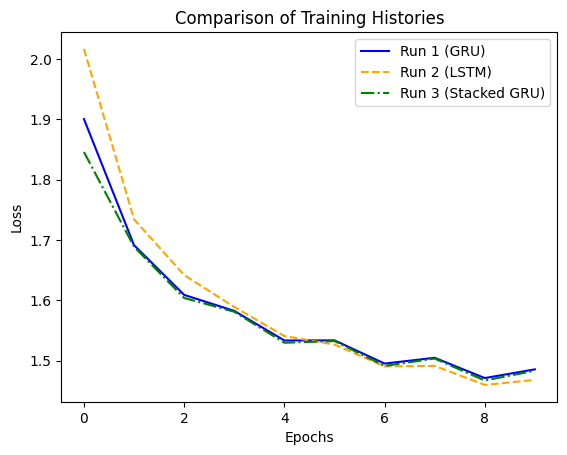

In [35]:
import matplotlib.pyplot as plt

# Extract the loss values from the three history objects
loss1 = history.history['loss']
loss2 = h2.history['loss']
loss3 = history3.history['loss']

# Plot the training losses
plt.plot(loss1, label="Run 1 (GRU)", linestyle='-', color='blue')
plt.plot(loss2, label="Run 2 (LSTM)", linestyle='--', color='orange')
plt.plot(loss3, label="Run 3 (Stacked GRU)", linestyle='-.', color='green')

# Add labels, title, and legend
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison of Training Histories")
plt.legend()

# Display the plot
plt.show()